In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from hamiltonians import sshk, htotalK
from utils import calculate_phase

# Total topological invariant

In [2]:
g = 0.1
hop = np.array([1, 2])
nmax = 50
Omegavals = np.linspace(0.4, 10, 50)
kvals = np.linspace(-np.pi, np.pi, 101)

In [3]:
hyperh = np.zeros([np.size(Omegavals), np.size(kvals), 2 * (nmax + 1), 2 * (nmax + 1)], dtype='complex')
for i, Omega in enumerate(Omegavals):
    for j, k in enumerate(kvals):
        hyperh[i, j] = htotalK(hop, k, g, Omega, nmax)[:]

In [4]:
_, hyperavec = np.linalg.eigh(hyperh)

In [5]:
phases = []
for i in range(np.size(Omegavals)):
    phases.append(calculate_phase(hyperavec[i], nphases=2))
phases = np.array(phases)

(-1.05, 1.05)

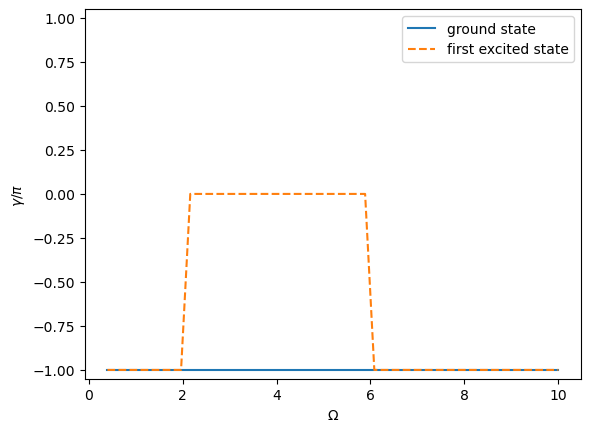

In [6]:
plt.plot(Omegavals, phases[:, 0] / np.pi, label='ground state')
plt.plot(Omegavals, phases[:, 1] / np.pi, '--', label='first excited state')

plt.legend()

plt.xlabel(r"$\Omega$")
plt.ylabel(r"$\gamma/\pi$")
plt.ylim(-1.05, 1.05)

# Topological invariant for the SSH chain

In [7]:
hop = np.array([1, 2])
kvals = np.linspace(-np.pi, np.pi, 101)

hssh_kvals = [sshk(hop, k)[:] for k in kvals]
_, avecs = np.linalg.eigh(np.array(hssh_kvals))

In [8]:
phase0 = calculate_phase(avecs, nphases=1)

In [9]:
phase0

array([-3.14159265])

# Topological invariant for the resonant contribution

In [10]:
pauliy = np.array([[0, -1j], [1j, 0]])


def rotating_frame_hamiltonian(n, hop, k, g, Omega):
    e0 = np.sqrt(hop[0] ** 2 + hop[1] ** 2 + 2 * hop[0] * hop[1] * np.cos(k))
    gamma = (hop[0] + hop[1]) * np.sin(k) / e0
    h = np.zeros([2, 2], dtype='complex')
    h[0, 0] = n * Omega + e0
    h[1, 1] = (n + 1) * Omega - e0
    h[0, 1] = -1j * g * np.sqrt(n + 1) * gamma
    h[1, 0] = 1j * g * np.sqrt(n + 1) * gamma
    return sp.linalg.expm(1j * np.pi * pauliy / 4) @ h @ sp.linalg.expm(-1j * np.pi * pauliy / 4)

In [11]:
def total(n, hop, k, g, Omega):
    e0 = np.sqrt(hop[0] ** 2 + hop[1] ** 2 + 2 * hop[0] * hop[1] * np.cos(k))
    gamma = (hop[0] + hop[1]) * np.sin(k) / e0
    h = np.zeros([2, 2], dtype='complex')
    h[0, 1] = e0 * (e0 - Omega / 2 - 1j * g * np.sqrt(n + 1) * gamma) / (hop[0] + hop[1] * np.exp(-1j * k))
    h[1, 0] = np.conjugate(h[0, 1])
    return h + 1 * (n + 1 / 2) * Omega * np.identity(2)

In [12]:
n = 0
g = 0.35
hop = np.array([1, 2])
Omegavals = np.linspace(0.4, 10, 100)
kvals = np.linspace(-np.pi, np.pi, 101, endpoint=True)

In [13]:
hyperh_resonant = np.zeros([np.size(Omegavals), np.size(kvals), 2, 2], dtype='complex')
hyperh_total = np.zeros([np.size(Omegavals), np.size(kvals), 2, 2], dtype='complex')
for i, Omega in enumerate(Omegavals):
    for j, k in enumerate(kvals):
        hyperh_resonant[i, j] = rotating_frame_hamiltonian(n, hop, k, g, Omega)
        hyperh_total[i, j] = total(n, hop, k, g, Omega)

In [14]:
hyperaval_resonant, hyperavec_resonant = np.linalg.eigh(hyperh_resonant)
hyperaval_total, hyperavec_total = np.linalg.eigh(hyperh_total)

In [15]:
phases_resonant = []
phases_total = []
for i in range(np.size(Omegavals)):
    phases_resonant.append(calculate_phase(hyperavec_resonant[i], nphases=1))
    phases_total.append(calculate_phase(hyperavec_total[i], nphases=1))
phases_resonant = np.array(phases_resonant)
phases_total = np.array(phases_total)

Text(0, 0.5, '$\\gamma/\\pi$')

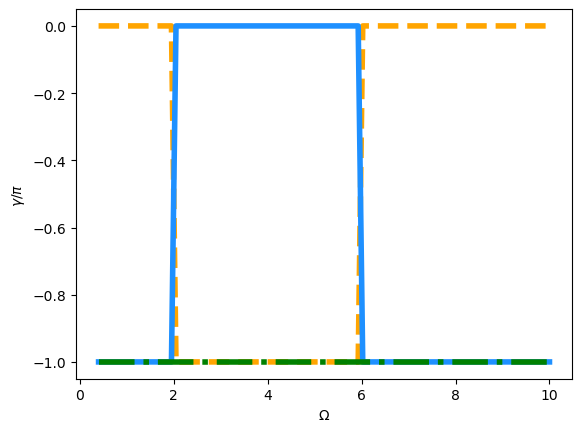

In [16]:
plt.plot(Omegavals, phases_resonant[:, 0] / np.pi, '--', linewidth=4, color='orange')
plt.plot(Omegavals, phases_total[:, 0] / np.pi, linewidth=4, color='dodgerblue')
plt.plot(Omegavals, phase0 * np.ones(np.size(Omegavals)) / np.pi, '-.', linewidth=4, color='green')
plt.xlabel(r"$\Omega$")
plt.ylabel(r"$\gamma/\pi$")


# Winding number

In [17]:
def bloch_trajectory(n, hop, g, Omega):
    kvals = np.linspace(-np.pi, np.pi, 101)
    v_x = []
    v_y = []
    v_z = []

    for k in kvals:
        h = total(n, hop, k, g, Omega)
        v_x.append(np.real(h[1, 0]))
        v_y.append(np.imag(h[1, 0]))
        v_z.append((h[0, 0] - h[1, 1]) / 2)

    return v_x, v_y, v_z

In [18]:
n = 0
g = 0.1
hop = np.array([1, 2])
Omega_list = [4.5, 6, 7]
v_list = []

for Omega in Omega_list:
    v_list.append(bloch_trajectory(n, hop, g, Omega))

(-2.0, 2.0)

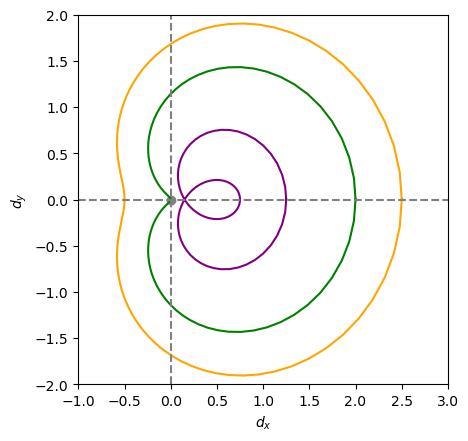

In [19]:
fig, ax = plt.subplots()
cl = ['purple', 'green', 'orange']

for i in range(len(Omega_list)):
    ax.plot(v_list[i][0], v_list[i][1], color=cl[i])
ax.scatter(0, 0, color='gray')
ax.hlines(0, -1, 3, linestyle='--', color='gray')
ax.vlines(0, -2, 2, linestyle='--', color='gray')
ax.set_aspect('equal')

ax.set_xlabel(r"$d_x$")
ax.set_ylabel(r"$d_y$")

ax.set_xlim(-1, 3)
ax.set_ylim(-2, 2)